In [21]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import torch
import torchvision

from torchvision import transforms 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [22]:
train_df = pd.read_csv('/kaggle/input/global-wheat-detection/train.csv')
submit = pd.read_csv("/kaggle/input/global-wheat-detection/sample_submission.csv")
train_df.shape

(147793, 5)

In [23]:
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [24]:
# Dropping unrequired columns
train_df = train_df.drop(['width', 'height', 'source'], axis=1)

In [25]:
# Checking the number of unique images in train_df
train_df['image_id'].nunique() 

3373

In [26]:
# Checking the maximum number of bounding boxes present in an image
(train_df['image_id'].value_counts()).max()  

116

In [27]:
# Checking the minimum number of bounding boxes present in an image
(train_df['image_id'].value_counts()).min()  

1

In [28]:
# bbox in each row is formatted [xmin, ymin, width, height]
# Splitting the bounding box  

train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for 

In [29]:
train_df.head()

,image_id,x,y,w,h
0,b6ab77fd7,834.0,222.0,56.0,36.0
1,b6ab77fd7,226.0,548.0,130.0,58.0
2,b6ab77fd7,377.0,504.0,74.0,160.0
3,b6ab77fd7,834.0,95.0,109.0,107.0
4,b6ab77fd7,26.0,144.0,124.0,117.0


In [30]:
# Splitting the data into test and validation sets

image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [31]:
train_df.shape, valid_df.shape

((122787, 5), (25006, 5))

In [32]:
trans = transforms.Compose([transforms.ToTensor()])   #Apply transform to image 

In [33]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None,train=True):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.train=train

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        #Applying transformations
        if self.transforms is not None:  
            image = self.transforms(image)
         
         # For test data
        if(self.train==False): 
            return image, image_id
        
        # For train and val data        
           
        # getting all the records for a particular image_id
        records = self.df[self.df['image_id'] == image_id]   
        
     
        # initially boxes = [xmin, ymin, width, height]
        boxes = records[['x', 'y', 'w', 'h']].values
        # converting width to xmax
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        # converting height to ymax
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
       
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # Now, boxes = [xmin, ymin, xmax, ymax]
        # area = w*h => (ymax-ymin)*(xmax-xmin) 
        # creating a series of area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # Since there is only 1 class present (wheat) in all the bboxes
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)   

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        return image, target, image_id 

In [34]:
train_dir = '/kaggle/input/global-wheat-detection/train'
test_dir = '/kaggle/input/global-wheat-detection/test'

In [44]:
# Returns the average loss
class Averager:       
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1
        
    #@property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations     

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
        
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, train_dir, trans, True)
valid_dataset = WheatDataset(valid_df, train_dir, trans, True)


train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [45]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

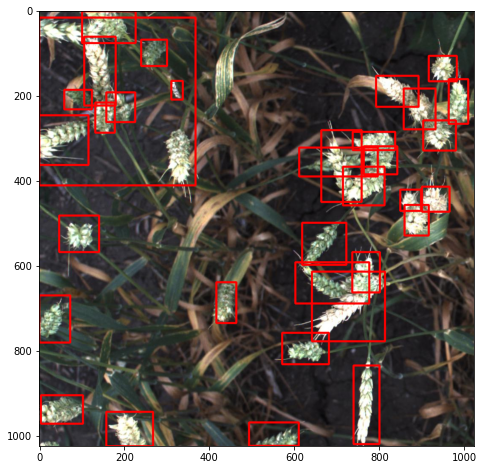

In [46]:
# images, targets, image_ids because Dataset class was returning these
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[4]['boxes'].cpu().numpy().astype(np.int32)
sample = images[4].permute(1,2,0).cpu().numpy().copy()  #Without using .copy(), there will be an error, the reason for which according to Stackoverflow, only God and Gary Bradski know

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    #cv2.rectangle(image, start_point, end_point, color, thickness)
    cv2.rectangle(sample,
                  (int(box[0]), int(box[1])),
                  (int(box[2]), int(box[3])),
                  (220, 0, 0),3)
    
# ax.set_axis_off()
ax.imshow(sample)

In [47]:
# loading the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [48]:
# 1 class is for wheat and the other is the background
num_classes = 2  

# Getting the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

WEIGHTS_FILE = '../input/fasterrcnn/fasterrcnn_resnet50_fpn_best.pth'

# loading the pre-trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE))  


<All keys matched successfully>

In [49]:
model.train()
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.00001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

num_epochs = 5

loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)   ##Return the loss

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)  #Average out the loss

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

Iteration #50 loss: 0.9237065315246582
Iteration #100 loss: 0.7010208368301392
Iteration #150 loss: 0.6977008581161499
Epoch #0 loss: <bound method Averager.value of <__main__.Averager object at 0x7fc5d44e3710>>
Iteration #200 loss: 0.8044177293777466
Iteration #250 loss: 0.7113312482833862
Iteration #300 loss: 0.6298345327377319
Epoch #1 loss: <bound method Averager.value of <__main__.Averager object at 0x7fc5d44e3710>>
Iteration #350 loss: 0.7237800359725952
Iteration #400 loss: 0.8533914089202881
Iteration #450 loss: 0.5459654331207275
Iteration #500 loss: 0.7360596060752869
Epoch #2 loss: <bound method Averager.value of <__main__.Averager object at 0x7fc5d44e3710>>


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc5d7808950>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 921, in wait
    ready = selector.select(timeout)
  File "/opt/conda/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
test_dataset = WheatDataset(submit,test_dir,trans,False)


In [ ]:
test_data_loader = DataLoader( test_dataset, batch_size=8, shuffle=False)

In [ ]:
detection_threshold = 0.45

In [ ]:
def format_prediction_string(boxes, scores): ## Define the formate for storing prediction results
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [ ]:
#Making the prediction
results=[]
model.eval()
 
for images, image_ids in test_data_loader:
    
    images = list(image.to(device) for image in images)
    outputs = model(images)
    
    for i, image in enumerate(images):
        boxes = outputs[i]['boxes'].data.cpu().numpy()  #[Xmin,Ymin,Xmax,Ymax]
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        
        image_id = image_ids[i]
        
        #converting the box format to [Xmin,Ymin,W,H]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]         
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1] 
        
        #Storing the image id and boxes and scores in result dict
        
        result = {                                     
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)}
          
        #Appending the result dict to results list
        results.append(result)  

In [ ]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

In [ ]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

In [ ]:
# plotting some of the predictions

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (int(box[0]), int(box[1])),
                  (int(box[2]), int(box[3])),
                  (220, 0, 0), 2)
ax.set_axis_off()
ax.imshow(sample)

In [ ]:
test_df.to_csv('submission.csv', index=False)
